In [2]:
import numpy as np
import matplotlib.pyplot as plt


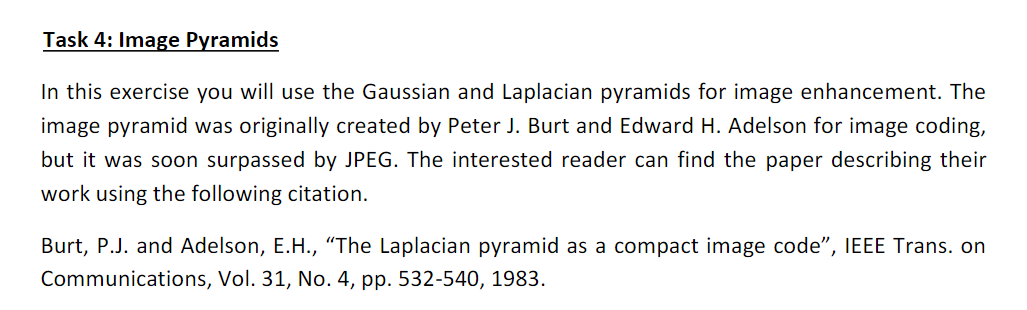

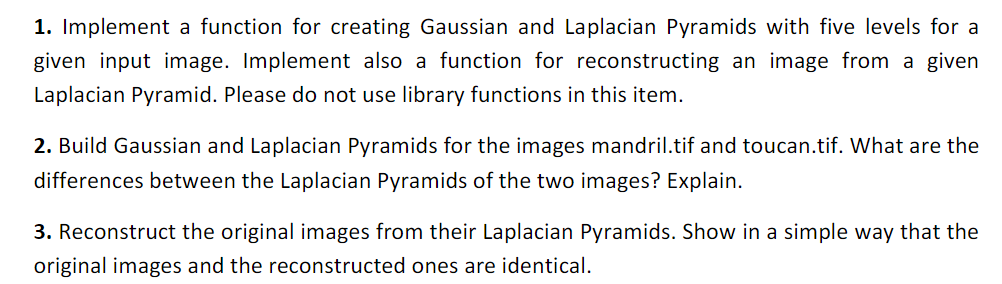

In [1]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
import os

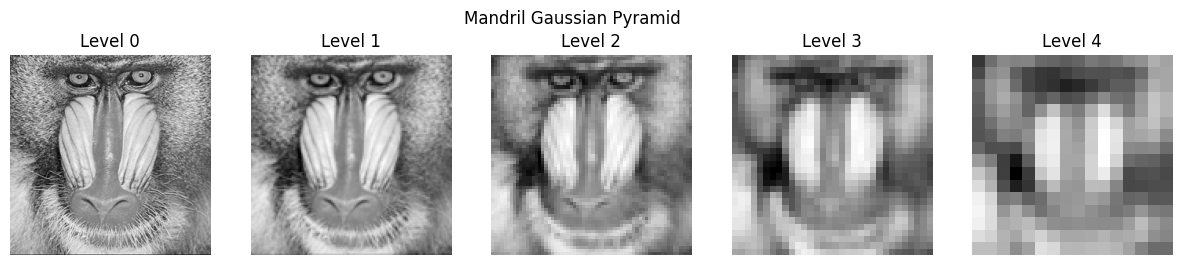

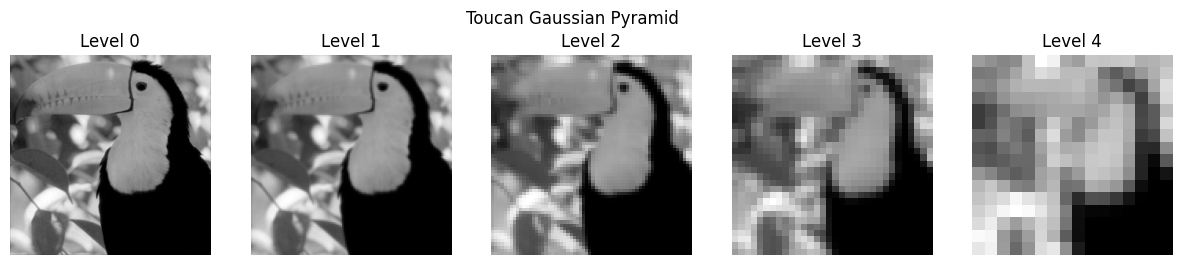

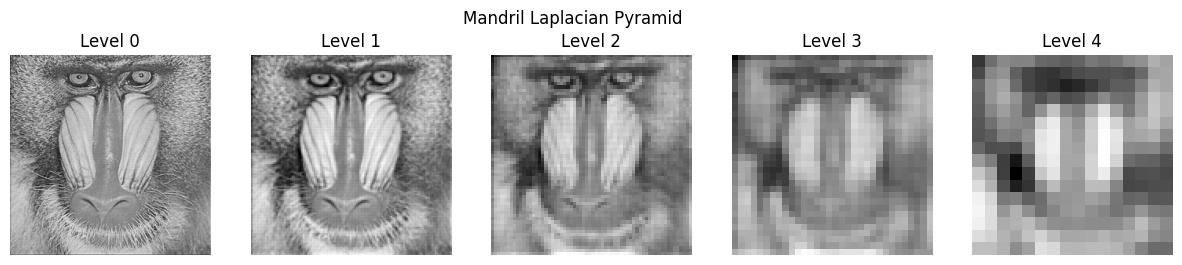

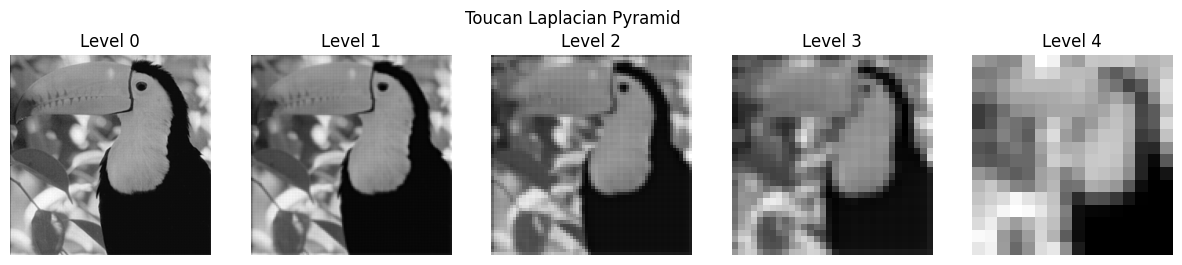

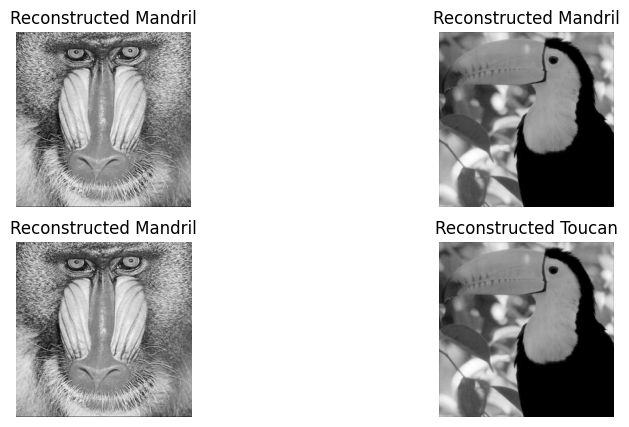

Mandril Image Reconstruction Difference: 0.0
Toucan Image Reconstruction Difference: 0.0


In [15]:
import numpy as np
import matplotlib.pyplot as plt


def gaussian_kernel(size, sigma=1):
    """Generates a 2D Gaussian kernel."""
    kernel_1d = np.linspace(-(size // 2), size // 2, size)
    x, y = np.meshgrid(kernel_1d, kernel_1d)
    kernel = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    return kernel / np.sum(kernel)


def convolve(image, kernel):
    """Convolves an image with a given kernel."""
    k = kernel.shape[0] // 2
    padded_image = np.pad(image, k, mode='edge')
    convolved_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i + kernel.shape[0], j:j + kernel.shape[1]]
            convolved_image[i, j] = np.sum(region * kernel)
    return convolved_image


def downsample(image):
    """Downsamples the image by a factor of 2."""
    return image[::2, ::2]


def upsample(image):
    """Upsamples the image by a factor of 2."""
    upsampled = np.zeros((image.shape[0] * 2, image.shape[1] * 2), dtype=image.dtype)
    upsampled[::2, ::2] = image
    kernel = gaussian_kernel(5, sigma=1)
    return convolve(upsampled, kernel)


def gaussian_pyramid(image, levels):
    gp = [image]
    for i in range(1, levels):
        image = downsample(convolve(image, gaussian_kernel(5, sigma=1)))
        gp.append(image)
    return gp


def laplacian_pyramid(gp):
    lp = []
    for i in range(len(gp) - 1):
        GE = upsample(gp[i + 1])
        if GE.shape != gp[i].shape:
            GE = GE[:gp[i].shape[0], :gp[i].shape[1]]
        L = gp[i] - GE
        lp.append(L)
    lp.append(gp[-1])
    return lp


def reconstruct_image(lp):
    image = lp[-1]
    for i in range(len(lp) - 2, -1, -1):
        image = upsample(image)
        if image.shape != lp[i].shape:
            image = image[:lp[i].shape[0], :lp[i].shape[1]]
        image = image + lp[i]
    return image


# Helper function to display images in subplots
def display_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()
    for img, title, ax in zip(images, titles, axes):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def calculate_ssd(img1, img2):
    """Computing the sum of squared differences (SSD) between two images."""
    if img1.shape != img2.shape:
        print("Images don't have the same shape.")
        return None
    return np.sum((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32))**2)

def plot_pyramid(pyramid, title):
    levels = len(pyramid)
    fig, axes = plt.subplots(1, levels, figsize=(15, 3))
    for i, img in enumerate(pyramid):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Level {i}')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()


# Loading images
mandril = plt.imread('Images/Task4/mandril.tif')
toucan = plt.imread('Images/Task4/toucan.tif')
# Convert images to grayscale
if mandril.ndim == 3:
    mandril = np.mean(mandril, axis=2)
if toucan.ndim == 3:
    toucan = np.mean(toucan, axis=2)
# Generating Gaussian and Laplacian Pyramids
levels = 5
gp_mandril = gaussian_pyramid(mandril, levels)
lp_mandril = laplacian_pyramid(gp_mandril)
gp_toucan = gaussian_pyramid(toucan, levels)
lp_toucan = laplacian_pyramid(gp_toucan)
# Reconstructing the original images
reconstructed_mandril = reconstruct_image(lp_mandril)
reconstructed_toucan = reconstruct_image(lp_toucan)

# Plot Gaussian pyramid
plot_pyramid(gp_mandril, 'Mandril Gaussian Pyramid')
plot_pyramid(gp_toucan, 'Toucan Gaussian Pyramid')

# Plot Laplacian pyramid
plot_pyramid(lp_mandril, 'Mandril Laplacian Pyramid')
plot_pyramid(lp_toucan, 'Toucan Laplacian Pyramid')

# Plot reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(mandril, cmap='gray')
plt.title('Origin Mandril')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(toucan, cmap='gray')
plt.title('Origin toucan')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(reconstructed_mandril, cmap='gray')
plt.title('Reconstructed Mandril')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(reconstructed_toucan, cmap='gray')
plt.title('Reconstructed Toucan')
plt.axis('off')

plt.show()

print('Mandril Image Reconstruction Difference:', calculate_ssd(mandril, reconstructed_mandril))
print('Toucan Image Reconstruction Difference:', calculate_ssd(toucan, reconstructed_toucan))


In [ ]:
# Load focus images
focus1 = plt.imread('Images/Task4/focus1.tif')
focus2 = plt.imread('Images/Task4/focus2.tif')


def focus_blend(focus1, focus2, levels):
    # Create Gaussian pyramids
    gp_focus1 = gaussian_pyramid(focus1, levels)
    gp_focus2 = gaussian_pyramid(focus2, levels)

    # Create Laplacian pyramids
    lp_focus1 = laplacian_pyramid(gp_focus1)
    lp_focus2 = laplacian_pyramid(gp_focus2)

    # Blend Laplacian pyramids
    lp_blend = []
    for l1, l2 in zip(lp_focus1, lp_focus2):
        mask = np.abs(l1) > np.abs(l2)
        blend = l1 * mask + l2 * (1 - mask)
        lp_blend.append(blend)

    # Reconstruct the final blended image
    blended_image = reconstruct_image(lp_blend)
    return blended_image


 # Load focus images
focus1 = plt.imread('Images/Task4/focus1.tif')
focus2 = plt.imread('Images/Task4/focus2.tif')
# Convert images to grayscale
if focus1.ndim == 3:
    focus1 = np.mean(focus1, axis=2)
if focus2.ndim == 3:
    focus2 = np.mean(focus2, axis=2)
# Blend the images using focus blending
levels = 5
blended_image = focus_blend(focus1, focus2, levels)
# Collecting images and titles for display
images = [focus1, focus2, blended_image]
titles = ['Focus Image 1', 'Focus Image 2', 'Blended Image']
# Displaying the images
display_images(images, titles, 1, 3)

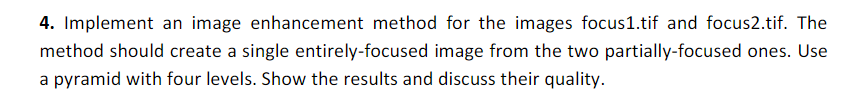

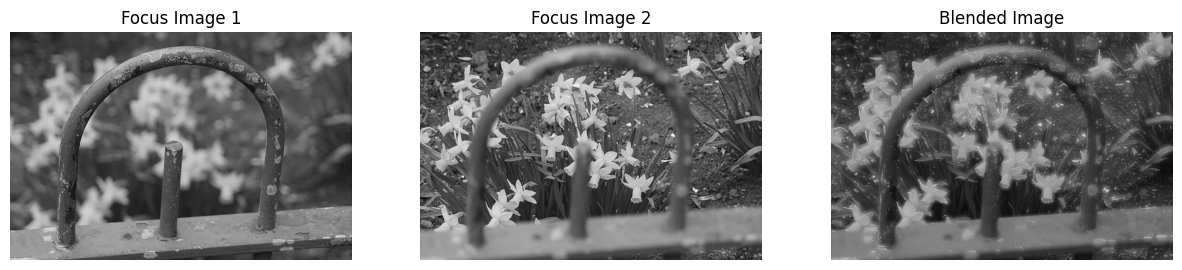

In [10]:

def focus_blend(focus1, focus2, levels):
    # Create Gaussian pyramids
    gp_focus1 = gaussian_pyramid(focus1, levels)
    gp_focus2 = gaussian_pyramid(focus2, levels)

    # Create Laplacian pyramids
    lp_focus1 = laplacian_pyramid(gp_focus1)
    lp_focus2 = laplacian_pyramid(gp_focus2)

    # Blend Laplacian pyramids
    lp_blend = []
    for l1, l2 in zip(lp_focus1, lp_focus2):
        mask = np.abs(l1) > np.abs(l2)
        blend = l1 * mask + l2 * (1 - mask)
        lp_blend.append(blend)

    # Reconstruct the final blended image
    blended_image = reconstruct_image(lp_blend)
    return blended_image

# Load focus images
focus1 = plt.imread('Images/Task4/focus1.tif')
focus2 = plt.imread('Images/Task4/focus2.tif')

# Convert images to grayscale
if focus1.ndim == 3:
    focus1 = np.mean(focus1, axis=2)
if focus2.ndim == 3:
    focus2 = np.mean(focus2, axis=2)



# Blend the images using focus blending
blended_image = focus_blend(focus1, focus2, 4)

 # Display the photos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(focus1, cmap='gray')
axes[0].set_title('Focus Image 1')
axes[0].axis('off')
axes[1].imshow(focus2, cmap='gray')
axes[1].set_title('Focus Image 2')
axes[1].axis('off')
axes[2].imshow(blended_image, cmap='gray')
axes[2].set_title('Blended Image')
axes[2].axis('off')
plt.show()
    